**1)** **Loading Dataset** from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd

# Importing the Data file
data = pd.read_csv('/content/gdrive/MyDrive/Sentiment/newData.csv')

# Preview Data
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,i was feeling a little low few days back,sadness
3,i also feel disillusioned that someone who cla...,sadness
4,i wish you knew every word i write i write for...,sadness


(121187, 2)
(141067, 2)
(47712, 2)


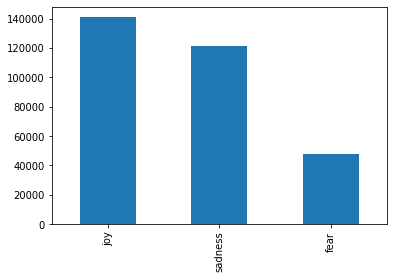

In [ ]:
# Visualize the Samples
print(data[data['emotions']=='sadness'].shape)
print(data[data['emotions']=='joy'].shape)
print(data[data['emotions']=='fear'].shape)

# Plotting Graph
data.emotions.value_counts().plot.bar()

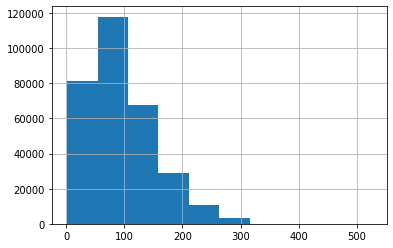

count    309966.000000
mean         96.233003
std          55.920283
min           2.000000
25%          53.000000
50%          85.000000
75%         127.000000
max         525.000000
dtype: float64

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Analyzing Review Lengths
reviews = [len(x) for x in data['text']]
pd.Series(reviews).hist()
plt.show()

# Summarizing the Analysis
pd.Series(reviews).describe()

**2) Data Preprocessing**

In [ ]:
import re

# Converting to lower case
data['text'] = data['text'].apply(lambda x: x.lower())

# Removing Punctuations
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenizing the text using in-built function
tokenizer = Tokenizer(num_words = 5000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

# The function map the words to integers, ands also pads the sentences, wherever required  
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [ ]:
# Encoding the Labels
Y = pd.get_dummies(data['emotions']).values

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(216976, 96) (216976, 3)
(92990, 96) (92990, 3)


**3) Defining Model**

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# Defining Model Architecture
model = Sequential()

model.add(Embedding(5000, 64, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 96, 64)            320000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 96, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
None


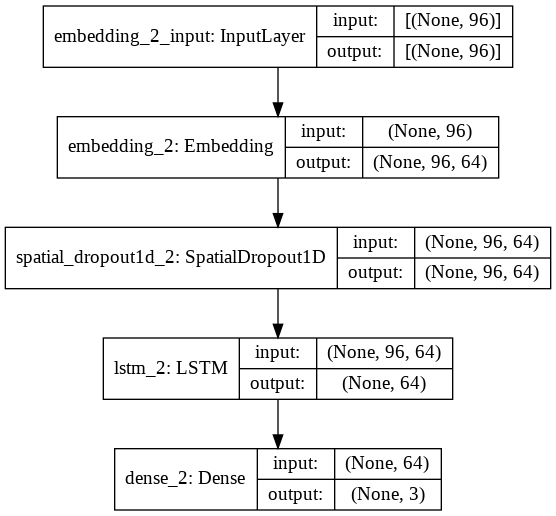

In [ ]:
from keras.utils.vis_utils import plot_model

# Plotting Model Architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Training the Model
batch_size = 16
model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 1)

Epoch 1/3
848/848 [==============================] - 386s 452ms/step - loss: 0.4743 - accuracy: 0.7848
Epoch 2/3
848/848 [==============================] - 389s 459ms/step - loss: 0.0353 - accuracy: 0.9855
Epoch 3/3
848/848 [==============================] - 386s 455ms/step - loss: 0.0231 - accuracy: 0.9891


In [ ]:
# Saving the Model
model.save('/content/gdrive/MyDrive/Sentiment/new model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Sentiment/new model/assets


In [ ]:
# Loading the Model
model = keras.models.load_model('/content/gdrive/MyDrive/Sentiment/new model')

**4) Results and Examples**

In [ ]:
# Predicting the Results
y_pred = model.predict(X_test)
y_pred = np.array([[1 if x > 0.5 else 0 for x in y ] for y in y_pred])

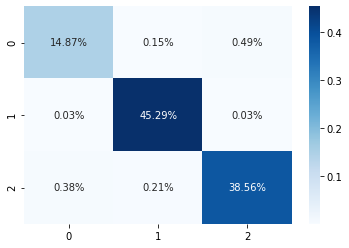

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred, average='micro'))
print("AUC ROC:", roc_auc_score(Y_test, y_pred, multi_class='ovr'))
print("Log Loss:", log_loss(Y_test, y_pred))

Accuracy: 0.9861490482847618
F1 Score: 0.9869397463286533
AUC ROC: 0.9861601844657049
Log Loss: 0.42481298574916665


In [ ]:
def Predictor(twt):
  twt = tokenizer.texts_to_sequences(twt)
  twt = pad_sequences(twt, maxlen = 96, dtype = 'int32', value = 0)
  sentiment = model.predict(twt ,batch_size = 1, verbose = 0)[0]
  sentiment = [float(i)/sum(sentiment) for i in sentiment]
  print(f"Depression: {((sentiment[0]*100)**1.3 + (sentiment[2]*100)**1.5)/10: 0.4}%")

In [ ]:
# Examples
Predictor(["i am depressed and discouraged"])
Predictor(["i am playing games"])
Predictor(["i am feeling lonely"])
Predictor(["please do not kill me"])
Predictor(["i really want to be alone"])
Predictor(["i commit suicide"])
Predictor(["i feel so good while talking to you"])

Depression:  97.51%
Depression:  15.06%
Depression:  99.91%
Depression:  17.01%
Depression:  70.56%
Depression:  71.95%
Depression:  3.342e-05%


#### The accuracy on custom samples *may not be high* due to the fact that we have not used a pre-complied dictionary, instead created one using the unique words of dataset only. 